# mHSP2: Process Single Simulation Output

Testing and development for processing mHSP2 output. This focuses on extracting our water balance components for the 12 HRUs and the five reaches and aggregating these to watershed-wide water balance quantities.

Predefine our targets for analysis and quantities because know how the watershed is configured and what
are our water budget components.

* PERLND
    - IGWI, losses to inactive groundwater, represents deep infiltration or recharge, in $in/day$
    - Actual evapotranspiration is calculated as the total from a number of parameters. Check
      that TAET is matching the sum of the other five and then use TAET
        * AGWET, AET from active groundwater, $in/day$
        * BASET, AET from baseflow, $in/day$
        * CEPE, AET from interception storage, $in/day$
        * LZET, AET from lower soil zone, $in/day$
        * UZET, AET from upper soil zone, $in/day$
        * TAET, total PERLND AET, $in/day$
    - PERO, total outflow from pervious land, in $in/day$ composed of
        * SURO, surface storage outflow, $in/day$
        * IFWO, interflow outflow, $in/day$
        * AGWO, active groundwater outflow, $in/day$
* IMPLND is the simpliest structure because no infiltration
    - IMPEV, total simulated evaporation, in $in/day$
    - SURO, surface storage outflow, in $in/day$
* RCHRES
    - OVOL, volume of outflow to downstream, $af/day$
        - R005, OVOL1 is the volume of outflow from the domain, in $af/day$
            * This is total stream flow generted for the entire watershed
            * Needs to have the lateral inflow representing spring discharge removed to give
              runoff
        - R001, R002, R003, R004, use OVOL2 which is the outflow to groundwater from exit
          2, in $af/day$ 
    - VOLEV, volume of evaporation from stream segments, $af/day$

## Parameters and Imports

In [1]:
%matplotlib inline

In [2]:
import h5py
import pandas as pd
import numpy as np
import datetime as dt
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from copy import deepcopy

In [3]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [4]:
InHDF5 = r'C:\Working\Test_Models\modSA_mHSP2\DC_CalibmHSP2.h5'

In [5]:
OUT_DIR = r'C:\Working\Test_Models\modSA_mHSP2\Outputs'

In [6]:
Start_DT = dt.datetime( 2013, 1, 1 )
End_DT = dt.datetime( 2018, 9, 1 )

In [7]:
PLND = "PERLND"
IMLND = "IMPLND"
RRES = "RCHRES"

In [8]:
PTargs = [ "P001", "P002", "P003", "P004", "P005", "P006", "P007", 
           "P008", "P009", "P010", "P011", "P012" ]

In [9]:
ITargs = [ "I001", "I002", "I003", "I004", "I005", "I006", "I007", 
           "I008", "I009", "I010", "I011", "I012" ]

In [10]:
RTarg = [ "R001", "R002", "R003", "R004" ]
ROut = "R005"

In [11]:
HRU_Areas = { "HRU_1" : 25337.50,
              "HRU_2" : 10709.74,
              "HRU_3" : 8167.01,
              "HRU_4" : 7699.20,
              "HRU_5" : 14445.14,
              "HRU_6" : 5395.53,
              "HRU_7" : 18151.25,
              "HRU_8" : 5316.70,
              "HRU_9" : 8346.94,
              "HRU_10" : 2497.28,
              "HRU_11" : 3579.89,
              "HRU_12" : 4264.43,
            }
WS_Area = 113910.61

In [12]:
PL_Areas = { "P001" : 25100.45,
             "P002" : 10588.09,
             "P003" : 8078.48,
             "P004" : 7651.15,
             "P005" : 14436.69,
             "P006" : 5364.62,
             "P007" : 18151.25,
             "P008" : 5269.78, 
             "P009" : 8247.99,
             "P010" : 2462.13,
             "P011" : 3559.67,
             "P012" : 4242.42,
           }
PERV_Area = 113152.72

In [13]:
IL_Areas = { "I001" : 237.05,
             "I002" : 121.65,
             "I003" : 88.53,
             "I004" : 48.05,
             "I005" : 8.45,
             "I006" : 30.92,
             "I007" : 0.00,
             "I008" : 46.92,
             "I009" : 98.95,
             "I010" : 35.15,
             "I011" : 20.22,
             "I012" : 22.01,
}
IMP_Area = 757.89

For this particular case, also want to create an external time series dictionary.

In [14]:
TS_DICT = { "R001" : [ [ "PREC", "TS102" ], [ "POTEV", "TS103"] ],
            "R002" : [ [ "PREC", "TS104" ], [ "POTEV", "TS105"] ],  
            "R003" : [ [ "PREC", "TS106" ], [ "POTEV", "TS107"] ],  
            "R004" : [ [ "PREC", "TS108" ], [ "POTEV", "TS109"] ],  
            "R005" : [ [ "PREC", "TS110" ], [ "POTEV", "TS111"], ["IVOL", "TS136"]],  
            "P001" : [ [ "PREC", "TS112" ], [ "PETINP", "TS113"] ],  
            "P002" : [ [ "PREC", "TS114" ], [ "PETINP", "TS115"] ],  
            "P003" : [ [ "PREC", "TS116" ], [ "PETINP", "TS117"] ],  
            "P004" : [ [ "PREC", "TS118" ], [ "PETINP", "TS119"] ],  
            "P005" : [ [ "PREC", "TS120" ], [ "PETINP", "TS121"] ],  
            "P006" : [ [ "PREC", "TS122" ], [ "PETINP", "TS123"] ],  
            "P007" : [ [ "PREC", "TS124" ], [ "PETINP", "TS125"] ],  
            "P008" : [ [ "PREC", "TS126" ], [ "PETINP", "TS127"] ],  
            "P009" : [ [ "PREC", "TS128" ], [ "PETINP", "TS129"] ],  
            "P010" : [ [ "PREC", "TS130" ], [ "PETINP", "TS131"] ],  
            "P011" : [ [ "PREC", "TS132" ], [ "PETINP", "TS133"] ],  
            "P012" : [ [ "PREC", "TS134" ], [ "PETINP", "TS135"] ],  
            "I001" : [ [ "PREC", "TS112" ], [ "PETINP", "TS113"] ],  
            "I002" : [ [ "PREC", "TS114" ], [ "PETINP", "TS115"] ],  
            "I003" : [ [ "PREC", "TS116" ], [ "PETINP", "TS117"] ],  
            "I004" : [ [ "PREC", "TS118" ], [ "PETINP", "TS119"] ],  
            "I005" : [ [ "PREC", "TS120" ], [ "PETINP", "TS121"] ],  
            "I006" : [ [ "PREC", "TS122" ], [ "PETINP", "TS123"] ],  
            "I007" : [ [ "PREC", "TS124" ], [ "PETINP", "TS125"] ],  
            "I008" : [ [ "PREC", "TS126" ], [ "PETINP", "TS127"] ],  
            "I009" : [ [ "PREC", "TS128" ], [ "PETINP", "TS129"] ],  
            "I010" : [ [ "PREC", "TS130" ], [ "PETINP", "TS131"] ],  
            "I011" : [ [ "PREC", "TS132" ], [ "PETINP", "TS133"] ],  
            "I012" : [ [ "PREC", "TS134" ], [ "PETINP", "TS135"] ],  
          }

## Read and Process Results

Read in the results for each HRU and stream segment - at least the results that are needed for our calculations.

### HRUs

HRUs include PERLND and IMPLND.

In [15]:
NumHRU = len( PTargs )
NumHRU

12

In [16]:
HRU_Dict = dict()

In [17]:
pCols = [ "Prec_in", "Prec_af", "IGWI", "TAET", "PERO", "IMPEV", "ISURO", "TOT_Re_af", 
          "TOT_RO_af", "TOT_AET_af" ]

In [18]:
for iI in range(NumHRU):
    cHRU = "HRU_%d" % ( iI + 1 )
    tArea = HRU_Areas[cHRU]
    cPTarg = PTargs[iI]
    cITarg = ITargs[iI]
    pArea = PL_Areas[cPTarg]
    iArea = IL_Areas[cITarg]
    InPreTSId = TS_DICT[cPTarg][0][1]
    cKey = "/TIMESERIES/%s/" % InPreTSId
    PrecSeries = pd.read_hdf( InHDF5, cKey )
    DataDict = { "Prec_in" : np.array( PrecSeries.values, dtype=np.float32 ), }
    PrecDF = pd.DataFrame( index=PrecSeries.index, data=DataDict )
    HRUDF = PrecDF.loc[Start_DT:End_DT].copy()
    HRUDF["Prec_af"] = ( HRUDF["Prec_in"] / 12.0 ) * tArea
    cKey = "/RESULTS/PERLND_%s/PWATER/" % cPTarg
    pervDF = pd.read_hdf( InHDF5, cKey )
    HRUDF["IGWI"] = ( pervDF["IGWI"] / 12.0 ) * pArea
    HRUDF["TAET"] = ( pervDF["TAET"] / 12.0 ) * pArea
    HRUDF["PERO"] = ( pervDF["PERO"] / 12.0 ) * pArea
    cKey = "/RESULTS/IMPLND_%s/IWATER/" % cITarg
    impDF = pd.read_hdf( InHDF5, cKey )
    HRUDF["IMPEV"] = ( impDF["IMPEV"] / 12.0 ) * iArea
    HRUDF["ISURO"] = ( impDF["SURO"] / 12.0 ) * iArea
    # now do some calcs
    HRUDF["TOT_Re_af"] = HRUDF["IGWI"]
    HRUDF["TOT_RO_af"] = HRUDF["PERO"] + HRUDF["ISURO"]
    HRUDF["TOT_AET_af"] = HRUDF["TAET"] + HRUDF["IMPEV"]
    # add to our dictionary
    HRU_Dict[cHRU] = HRUDF
# end for

Now output to a spreadsheet for checking

In [19]:
OutFP = os.path.normpath( os.path.join( OUT_DIR, "HRU_Summary.xlsx" ) )
with pd.ExcelWriter( OutFP ) as writer:
    outKeys = list( HRU_Dict.keys() )
    for iI in outKeys:
        HRU_Dict[iI].to_excel( writer, sheet_name=iI, columns=pCols, index_label="Date", na_rep=str(np.nan) )
    # end for
# end with

In [20]:
NumRows = len( HRU_Dict["HRU_1"] )
NumRows

2070

In [21]:
AAPrecip_in = np.zeros( NumRows, dtype=np.float64 )
AAPrecip_af = np.zeros( NumRows, dtype=np.float64 )
TotAET = np.zeros( NumRows, dtype=np.float64 )
TotRO = np.zeros( NumRows, dtype=np.float64 )
TotRe = np.zeros( NumRows, dtype=np.float64 )

Go through and start our main counters

In [22]:
AETDDict = dict()
ReDDict = dict()
RODDict = dict()

In [23]:
for iI in range(NumHRU):
    cHRU = "HRU_%d" % ( iI + 1 )
    tArea = HRU_Areas[cHRU]
    AAPrecip_in += ( HRU_Dict[cHRU]["Prec_in"] * ( tArea / WS_Area ) )
    AAPrecip_af += HRU_Dict[cHRU]["Prec_af"]
    TotAET += HRU_Dict[cHRU]["TOT_AET_af"]
    TotRe += HRU_Dict[cHRU]["TOT_Re_af"]
    AETDDict[cHRU] = HRU_Dict[cHRU]["TOT_AET_af"].to_numpy()
    ReDDict[cHRU] = HRU_Dict[cHRU]["TOT_Re_af"].to_numpy()
    RODDict[cHRU] = HRU_Dict[cHRU]["TOT_RO_af"].to_numpy()
# end for

### RCHRES

In [24]:
NumRR = len( RTarg )
NumRR

4

In [25]:
RR_Dict = dict()

In [26]:
rCols = ["OVOL1", "OVOL2", "PRSUPY", "VOLEV", ]
rOutCols = ["OVOL1", "Spring_af", "Net_RO", "PRSUPY", "VOLEV", ]

In [27]:
for tKey in RTarg:
    cKey = "/RESULTS/RCHRES_%s/HYDR/" % tKey
    trrDF = pd.read_hdf( InHDF5, cKey )
    rrDF = trrDF[["OVOL1", "OVOL2", "PRSUPY", "VOLEV"]].copy()
    AETDDict[tKey] = rrDF["VOLEV"].to_numpy()
    ReDDict[tKey] = rrDF["OVOL2"].to_numpy()
    RODDict[tKey] = rrDF["OVOL1"].to_numpy()
    AAPrecip_af += rrDF["PRSUPY"].to_numpy()
    TotAET += rrDF["VOLEV"].to_numpy()
    TotRe += rrDF["OVOL2"].to_numpy()
    RR_Dict[tKey] = rrDF
# end for

Now do the outlet RCHRES which is special

In [28]:
InRRITSId = TS_DICT[ROut][2][1]
cKey = "/TIMESERIES/%s/" % InRRITSId
SpringSeries = pd.read_hdf( InHDF5, cKey )
DataDict = { "Spring_af" : np.array( SpringSeries.values, dtype=np.float32 ), }
SpringDF = pd.DataFrame( index=SpringSeries.index, data=DataDict )
OutDF = SpringDF.loc[Start_DT:End_DT].copy()

In [29]:
cKey = "/RESULTS/RCHRES_%s/HYDR/" % ROut
trrDF = pd.read_hdf( InHDF5, cKey )
rrDF = trrDF[["OVOL1", "PRSUPY", "VOLEV"]].copy()
rrDF["Spring_af"] = OutDF["Spring_af"]
rrDF["Net_RO"] = rrDF["OVOL1"] - rrDF["Spring_af"]
AETDDict[ROut] = rrDF["VOLEV"].to_numpy()
RODDict[ROut] = rrDF["OVOL1"].to_numpy()
AAPrecip_af += rrDF["PRSUPY"].to_numpy()
TotAET += rrDF["VOLEV"].to_numpy()
TotRO += rrDF["Net_RO"]
RR_Dict[ROut] = rrDF

In [30]:
OutFP = os.path.normpath( os.path.join( OUT_DIR, "RR_Summary.xlsx" ) )
with pd.ExcelWriter( OutFP ) as writer:
    for tKey in RTarg:
        RR_Dict[tKey].to_excel( writer, sheet_name=tKey, columns=rCols, index_label="Date", 
                                na_rep=str(np.nan) )
    # end for
    RR_Dict[ROut].to_excel( writer, sheet_name=ROut, columns=rOutCols, index_label="Date",
                            na_rep=str(np.nan) )
# end with

Collate the summary water budgets

In [31]:
AetDF = pd.DataFrame(index=OutDF.index, data=AETDDict )
RoDF = pd.DataFrame(index=OutDF.index, data=RODDict )
ReDF = pd.DataFrame(index=OutDF.index, data=ReDDict )

In [32]:
DataDict = { "Tot_Prec" : AAPrecip_af,
             "Tot_AET" : TotAET,
             "Tot_Re" : TotRe,
             "Tot_RO" : TotRO, }
WBDF = pd.DataFrame(index=OutDF.index, data=DataDict )

In [33]:
OutFP = os.path.normpath( os.path.join( OUT_DIR, "WB_Summary.xlsx" ) )
with pd.ExcelWriter( OutFP ) as writer:
    WBDF.to_excel( writer, sheet_name="Summary", index_label="Date", na_rep=str(np.nan))
    AetDF.to_excel( writer, sheet_name="AET", index_label="Date", na_rep=str(np.nan))
    RoDF.to_excel( writer, sheet_name="RO", index_label="Date", na_rep=str(np.nan))
    ReDF.to_excel( writer, sheet_name="Re", index_label="Date", na_rep=str(np.nan))
# end with

Add Tot_PET to WBDF for end of realization output. But then these time series of totals are what are compared between the pathways.

Compare our totals

In [34]:
Tot_Prec = WBDF["Tot_Prec"].sum()
Tot_AET = WBDF["Tot_AET"].sum()
Tot_Re = WBDF["Tot_Re"].sum()
Tot_RO = WBDF["Tot_RO"].sum()

In [35]:
CompTot = Tot_AET + Tot_Re + Tot_RO
Dsmoist = Tot_Prec - CompTot
Adj_AET = Tot_AET + Dsmoist
Tot_Prec, CompTot, Tot_Prec - CompTot

(1254795.4176752483, 1270014.658990414, -15219.241315165767)

In [36]:
Tot_Prec - ( Adj_AET + Tot_Re + Tot_RO )

0.0

(-1.1018660688102737,
 1.1061910476408578,
 -1.1070232314571415,
 1.1057801562803755)

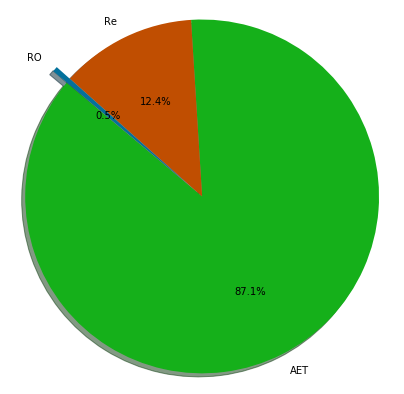

In [37]:
Fig1 = plt.figure()
Fig1.set_size_inches(7.0, 7.0)
ax11 = Fig1.add_subplot(111)
labels = ["AET", "Re", "RO"]
sizes = [Adj_AET, Tot_Re, Tot_RO]
colors = ["xkcd:green", "xkcd:burnt orange", "xkcd:ocean blue"]
explode = ( 0, 0.0, 0.1)
ax11.pie( sizes, explode=explode, labels=labels, colors=colors, 
          autopct='%1.1f%%', shadow=True, startangle=140 )
ax11.axis('equal')

## Plot RO

In [38]:
GAUGE_XLSX = r'C:\Working\Test_Models\modSA_mHSP2\DolanProcessed_Hr-Processed.xlsx'
GAUGE_SHT = "Daily"
GAUGE_HDR = "Discharge_cfs"
DCGauge = pd.read_excel( GAUGE_XLSX, sheet_name=GAUGE_SHT, header=0, index_col=0, parse_dates=True )

In [39]:
ConvCFStoAFD = lambda CFS: CFS * ( 1.0 / 43560.0 ) * ( ( 24.0 * 60.0 * 60.0 ) )

In [40]:
DCGauge = DCGauge[[GAUGE_HDR]].loc[Start_DT:End_DT].copy()

In [41]:
DCGauge["Discharge_af"] = DCGauge.apply( lambda row: ConvCFStoAFD( row[GAUGE_HDR] ), axis=1 )

In [42]:
display( HTML( RoDF.describe().to_html() ) )

,HRU_1,HRU_2,HRU_3,HRU_4,HRU_5,HRU_6,HRU_7,HRU_8,HRU_9,HRU_10,HRU_11,HRU_12,R001,R002,R003,R004,R005
count,2070.000000,2070.000000,2070.000000,2070.000000,2070.000000,2070.000000,2070.000000,2070.000000,2070.000000,2070.000000,2070.000000,2070.000000,2070.000000,2070.000000,2070.000000,2070.000000,2070.000000
mean,0.987131,0.511056,0.359701,2.216243,2.381332,1.380121,0.399130,0.295453,2.647879,0.861283,0.839033,0.947099,0.773477,3.060998,3.174857,3.046427,27.776344
std,2.927343,1.732042,1.360627,22.254665,21.946421,14.103422,5.294065,2.239650,21.220089,8.038447,8.391629,9.136118,0.454525,3.847888,5.858648,6.421374,7.329438
min,0.002636,0.000735,0.000000,0.000211,0.000077,0.000085,0.000000,0.000078,0.000246,0.000000,0.000027,0.000037,0.113708,0.111180,0.250086,0.085233,2.066755
25%,0.049242,0.010888,0.004607,0.021609,0.019511,0.013043,0.000000,0.002207,0.033837,0.003626,0.008153,0.011694,0.427318,1.161699,0.977933,0.968954,25.174642
50%,0.159943,0.043635,0.022040,0.120986,0.128460,0.070518,0.000000,0.009330,0.158741,0.028575,0.053306,0.074167,0.719298,2.111840,1.811101,1.647581,26.628134
75%,0.636079,0.214050,0.115574,0.747571,0.916430,0.535931,0.002824,0.056962,0.942735,0.242494,0.359745,0.480226,0.993777,3.687922,3.686865,3.563899,28.085107
max,68.258163,28.876303,23.912462,670.762878,606.466614,423.130371,232.188965,65.948074,608.832520,203.106323,264.152863,322.077942,2.641761,41.118649,67.704224,81.193848,107.755783


In [43]:
R005df = RR_Dict[ROut]

In [44]:
lenBF = len( R005df )
lenBF

2070

In [45]:
DTTimeList = list( R005df.index.to_pydatetime() )
type(DTTimeList)

list

In [46]:
BackDTList = deepcopy( DTTimeList )
BackDTList = BackDTList[::-1]
BackDTList[:5]

[datetime.datetime(2018, 9, 1, 0, 0),
 datetime.datetime(2018, 8, 31, 0, 0),
 datetime.datetime(2018, 8, 30, 0, 0),
 datetime.datetime(2018, 8, 29, 0, 0),
 datetime.datetime(2018, 8, 28, 0, 0)]

In [47]:
ZeroVals = [ 0.0 for x in range( lenBF ) ]
DSVals = list( R005df["Spring_af"].to_numpy() )
DSVals = DSVals[::-1]
DSVals[:5]

[24.049719, 23.999933, 23.951307, 23.903896, 23.857756]

In [48]:
ValsList = deepcopy( ZeroVals )
ValsList.extend( DSVals )
DTTimeList.extend( BackDTList )

In [49]:
disTicks = [ 5.0, 10.0, 50.0, 100.0, 500.0, 1000.0, 2000.0 ]

In [50]:
CStart_DT = Start_DT
CEnd_DT = End_DT

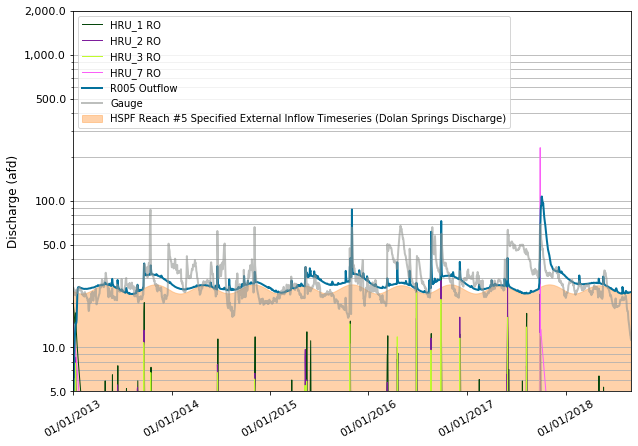

In [51]:
Fig1 = plt.figure()
Fig1.set_size_inches(10.0, 7.0)
ax11 = Fig1.add_subplot(111)
sfF = ax11.fill( DTTimeList, ValsList, color='xkcd:pale orange', alpha=0.5, 
                 label="HSPF Reach #5 Specified External Inflow Timeseries (Dolan Springs Discharge)")
#Rc5, = ax11.plot( RoDF.index, RoDF['R004'], color='xkcd:burnt orange', linewidth=1,
#                  label="R004 Outflow" )
mx1, = ax11.plot( RoDF.index, RoDF['HRU_1'], color='xkcd:forest green', linewidth=1,
                  label="HRU_1 RO" )
mx2, = ax11.plot( RoDF.index, RoDF['HRU_2'], color='xkcd:purple', linewidth=1,
                  label="HRU_2 RO" )
mx3, = ax11.plot( RoDF.index, RoDF['HRU_3'], color='xkcd:yellow green', linewidth=1,
                  label="HRU_3 RO" )
mx7, = ax11.plot( RoDF.index, RoDF['HRU_7'], color='xkcd:light magenta', linewidth=1,
                  label="HRU_7 RO" )
Rc5, = ax11.plot( RoDF.index, RoDF[ROut], color='xkcd:ocean blue', linewidth=2,
                  label="R005 Outflow" )
Dcg, = ax11.plot( DCGauge.index, DCGauge["Discharge_af"], color='xkcd:grey', linewidth=2,
                  label="Gauge", alpha=0.6 )
ax11.legend(loc='upper left')
ax11.set_yscale('log')
ax11.grid(b=True, which="both", axis='y')
ax11.set_ylim( ( 5.0, 2000.0))
ax11.set_xlim( (CStart_DT, CEnd_DT))
ax11.set_yticks( disTicks )
ax11.set_ylabel('Discharge (afd)', fontsize=12)
ax11.tick_params(axis='both', which='major', labelsize=11)
ax11.tick_params(axis='x', which='major', labelrotation=30.0)
ax11.xaxis.set_major_formatter( mpl.dates.DateFormatter("%m/%d/%Y") )
ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )

In [52]:
from IPython.display import display, HTML, Image

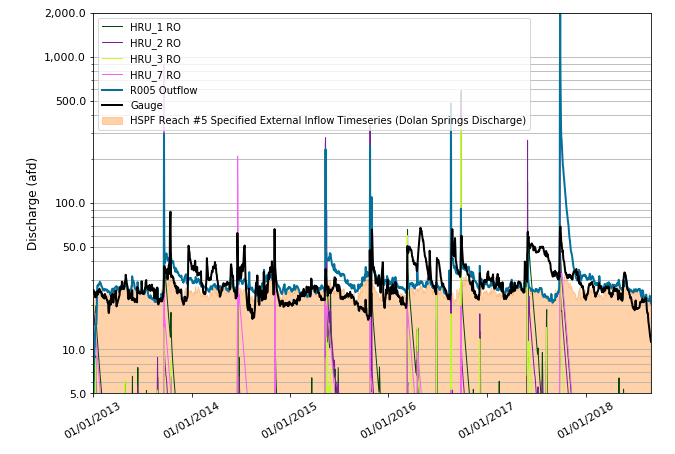

In [53]:
Image(filename=r'C:\Working\Test_Models\wg_mHSP2_Test\original_calib.PNG', width=700)